# Unit 3 - Supervised Learning Capstone
## Estimating the Possibility of Credit Card Default

#### John A. Fonte

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Explanation of the Dataset 

This is a collection of 2005 customer risk data acquired by Chung Hua University and Tamkang University of Taiwan. The goal in acquiring this data was to establish risk probability of default from general demographic features as well as timeliness of payments of the last six (6) months of payments.

__Original citation:__ Yeh, I. C., & Lien, C. H. (2009). _The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients._ Expert Systems with Applications, 36(2), 2473-2480.

__Link to Data:__ [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

In [2]:
# importing data
df = pd.read_csv('C:/Users/jafon/Documents/PythonMaterials/Data/Capstone-Unit3/credit card defaulters/creditcarddata - Data.csv')
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

              ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0             ...                      0          0          0         0   
1             ...                   3272       3455       3261         0   
2             ...                  14331      14948      15549      1518   
3             ...                  28314      28959      29547      2000   
4             ...                  20940      19146      19131      2000   

   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0       689         0         0         0         0   
1      1000      1000      1000         0      2000   
2      1500      1000      1000      1000      5000   
3      2019      1200      1100      1069      1000   
4     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0  

[5 rows x 25 columns]

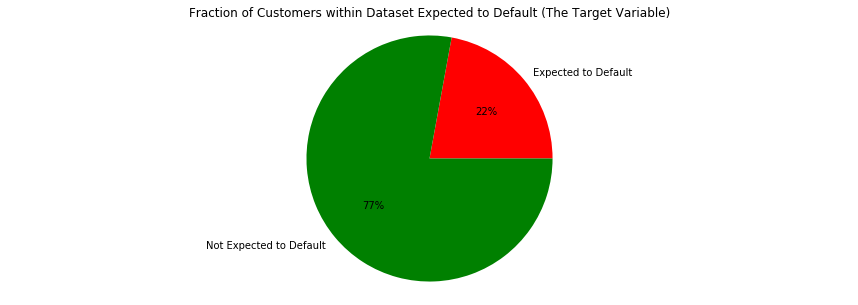

Total Number of Customers Reviewed is 30,000.


In [3]:
# Overview of the target variable: expected default (1) or not expected to default (0)


# default vs. non-default values taken from df['default payment next month']
pievalues = [6636/(6636 + 23364), 23364/(6636 + 23364)] 
pielabels = ['Expected to Default', 'Not Expected to Default']

plt.figure(figsize=(15,5)) 
plt.pie(pievalues, autopct='%d%%', labels=pielabels, colors=['red', 'green'])
plt.axis('equal')
plt.title('Fraction of Customers within Dataset Expected to Default (The Target Variable)')
plt.show()
print("Total Number of Customers Reviewed is 30,000.")

__NOTE:__ Class imbalance will be addressed later in this project.

In [4]:
# Quick adjustments to dataset - changing 1's and 2's to 0's and 1's for aesthetic convention 
# (i.e., DO ********NOT******** run more than once!)
df['SEX'] = df.SEX - 1
df['EDUCATION'] = df.EDUCATION - 1
df['MARRIAGE'] = df.MARRIAGE - 1

In [5]:
df.columns # viewing what I am working with

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

---
## Explanation of Columns
   - 1. __ID__ - The ID number associated with the particular credit card customer. <br><br>
   - 2. __Limit_Bal__ - The credit card limit (in USD) of the credit card associated with the particular customer.<br><br>
   - 3. __Sex__ - Sex of customer {O:Male, 1:Female}.<br><br>
   - 4. __Education__ - Highest education obtained by customer {0:graduate school, 1:undergraduate college, 2:high school, 3:other}.<br><br>
   - 5. __Marriage__ - Marital status of customer {0:married, 1:single, 2:"other"}.<br><br>
   - 6. __Age__ - Age (in number of years) of customer.<br><br>
   - 7. to 12. __Pay_X__ - History of past payments. Timing of payments for April to September 2005, with 'PAY_0' being the payment for the September 2005 bill, 'PAY_1' for August 2005 bill, and backwards from there. <br><br>
           - A '2' denotes that the payment was made 2 months after the due date, '3' denotes that the payment was made 3 months after the due date, ... '9' means 9 months or more the payment was made. A '0' or negative number denotes that the payment was made on \[or ahead of\] time.<br><br>
   - 13. to 18. __Monthly Bill Statement__ - The balance due for a given month from April to September 2005, with 'BILL_AMT1' being the bill statement for September 2005, 'BILL_AMT2' for August 2005, and backwards from there.<br><br>
   - 19. to 24. __Amount Paid per Month__ - The amount actually paid (in USD) by the customer for a given month from April to September 2005, with 'PAY_AMT1' being the amount paid towards the September 2005 bill, 'PAY_AMT2' towards the August 2005 bill, and backwards from there.   

# Data Cleaning

Before performing _any_ analysis on the data, we first need to curate the data; obviously, failing to do so first would result in visualizing incorrect, incomplete, and overall potentially misleading data.\*

Cleaning analysis entails:
- Checking if data types (int, float, str, etc.) are correct for each column
- Deleting or imputing _NaN_ values.
- Identifying "wonky" data points, and deciding what to do with them (delete them, transform them, etc.)

---
\* This will have to be done again if we include new or modified features.

In [65]:
# quick data cleaning check
df[df.isna().any(axis=1)]

# well...that'll do it!
# we will cross other cleaning bridges, 
# such as wrong data types and wonky data points as we go.

Empty DataFrame
Columns: [ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6, default payment next month]
Index: []

[0 rows x 25 columns]

# Data Visualization

Before delving into the minutia of the strength of individual features, it is important to at least _look_ at your data. As a brief overview, we will be analyzing default/no default in light of demographic data, particularly:
- Sex (M/F)
- Education (graduate school/undergraducate school/high school/"other")
- Marriage (married/single/"other")
- Age

It is a conscious decision not to visualize _every_ variable as that dilutes the analysis and clutters up the project as a whole. Remember, the goal of visualization is to understand the dataset better. Additional graphs provide diminishing returns of dataset understanding, and so a data scientist must be judicious in terms of what data features to further investigate.

Finally, included in these visualizations is a histogram analysis of the demographic data. Keeping tabs on normal data as opposed to non-normal data is important in machine learning, as many models assume a normal distribution to provide accurate results and predictions.

---
### Sex

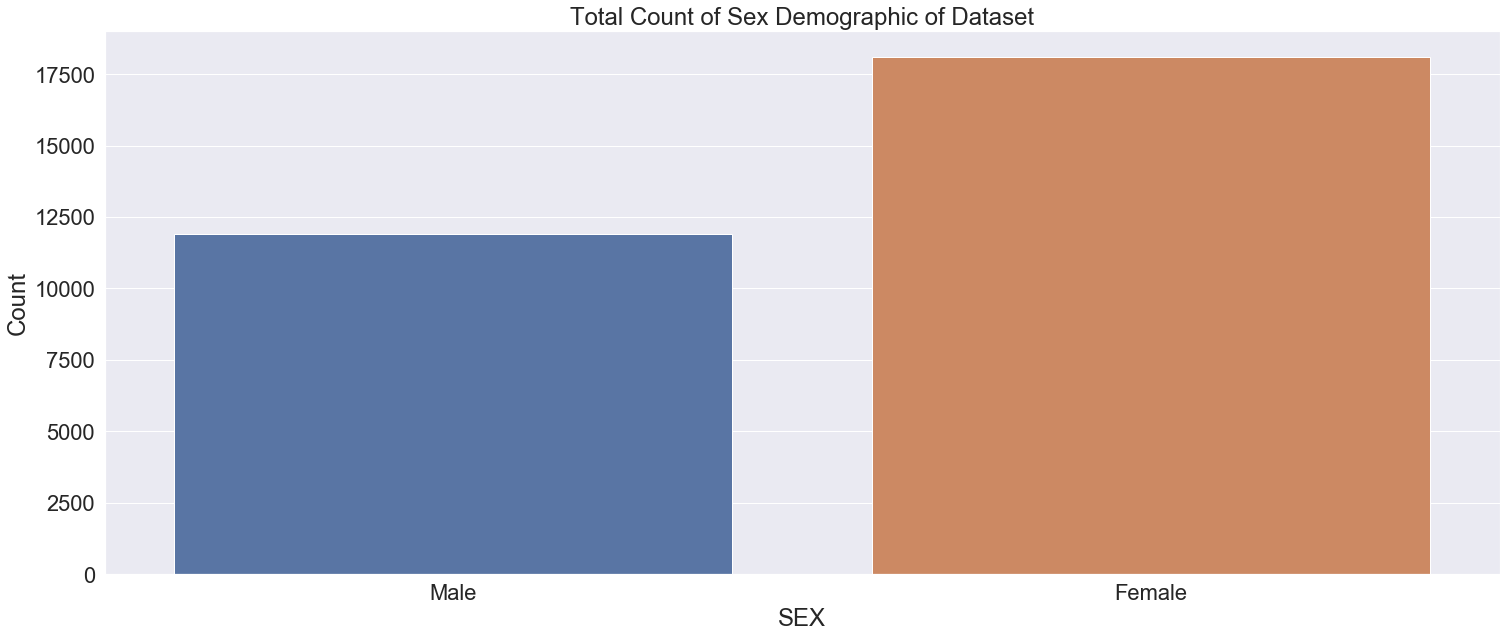

In [21]:
plt.figure(figsize=(25,10))

sns.set_style('darkgrid')
sns.set(font_scale = 2)

sns.countplot(x='SEX', data=df)
plt.title('Total Count of Sex Demographic of Dataset')
plt.ylabel('Count')
plt.xticks([0,1], ['Male', 'Female'])
plt.show()

Slightly imbalanced. Making a mental note...

---

The following visualizations will contain "sex" as a hue to other demographic features. Before moving onto those other demographic features, we will take an initial look into credit card balance differences in sex.

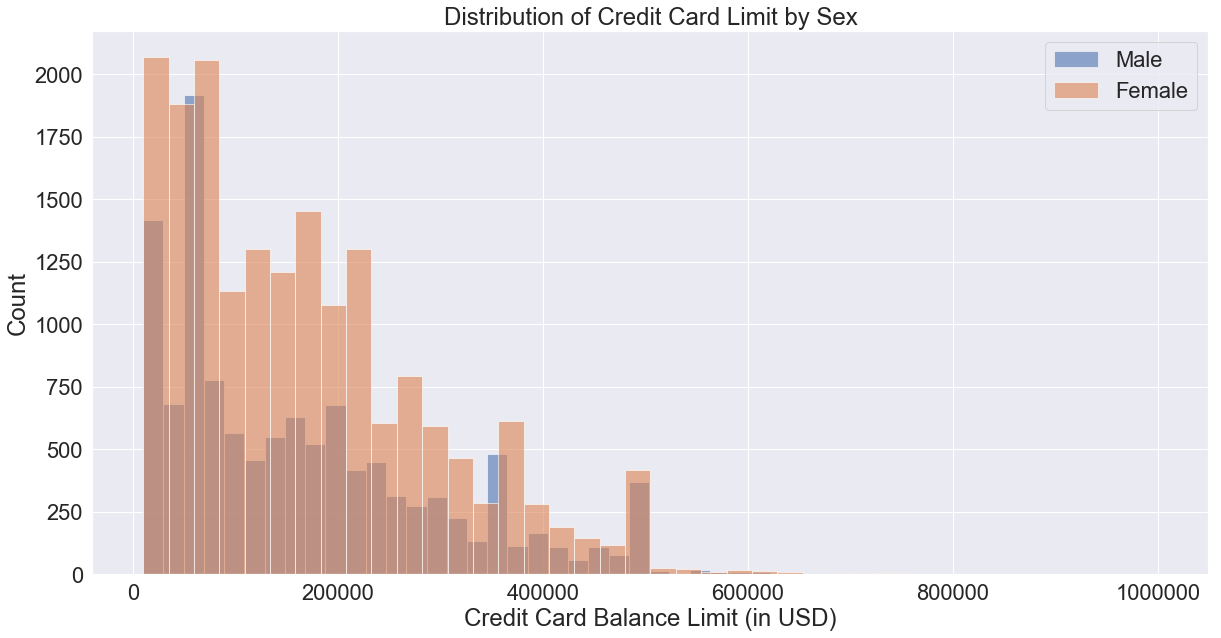

In [27]:
# doing initial histogram for check on normality of distribution

dfmale = df[df.SEX == 0].copy()
dffemale = df[df.SEX == 1].copy()

plt.figure(figsize=(20,10))

plt.hist(x=dfmale['LIMIT_BAL'], bins=40, alpha=0.6, label='Male')
plt.hist(x=dffemale['LIMIT_BAL'], bins=40, alpha=0.6, label='Female')
plt.legend()
plt.title('Distribution of Credit Card Limit by Sex')
plt.ylabel('Count')
plt.xlabel('Credit Card Balance Limit (in USD)')
#plt.hist(x=dffemale['Credit Balance Limit (USD)'], bins=40, alpha=0.6)
plt.show()

This non-normal distribution is expected; having a normal distribution of a credit card balance limit would be surprising. Accordingly, it is cautioned using this feature...

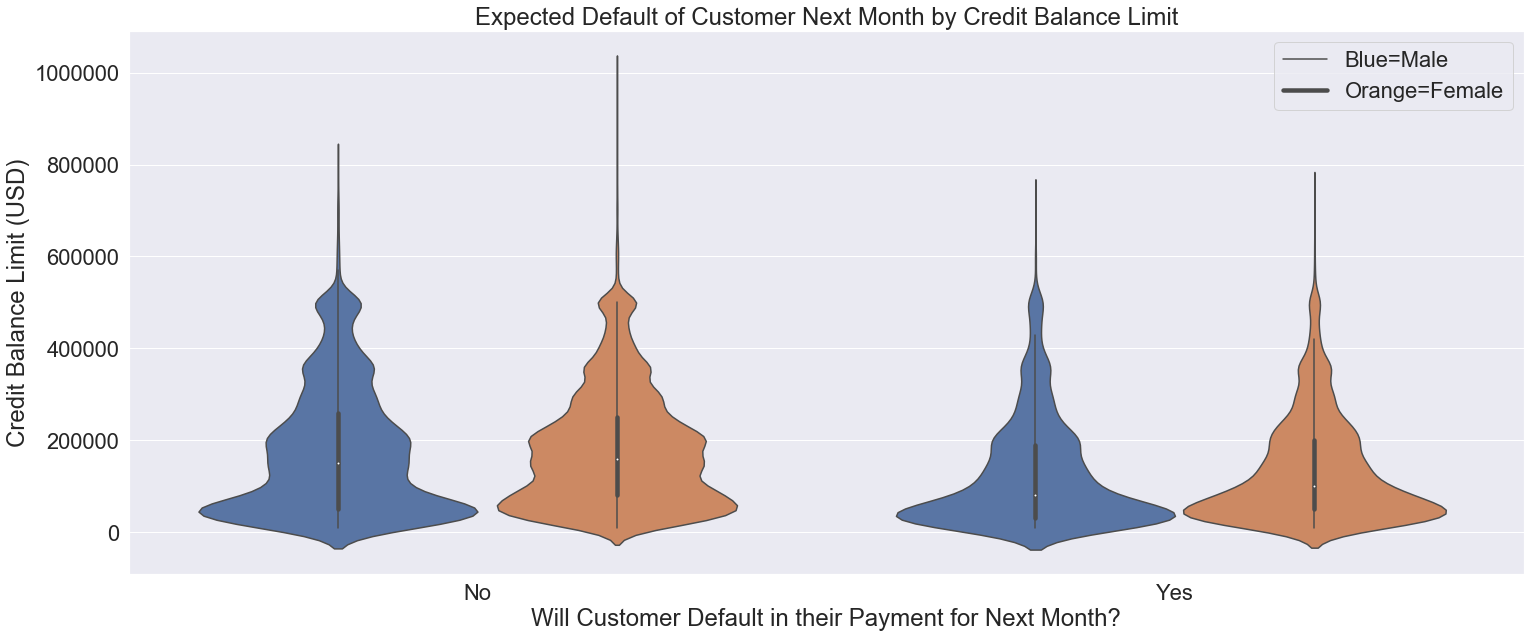

In [70]:
#--------------------------------------------------------
# Rest of visualizations will check if a demographic factors into default/no default

# Look at credit card balance via a violinplot

plt.figure(figsize=(25,10))

sns.set_style('darkgrid')
sns.set(font_scale = 2)

sns.violinplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', data=df)
plt.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper right')
plt.title('Expected Default of Customer Next Month by Credit Balance Limit')
plt.ylabel('Credit Balance Limit (USD)')
plt.xlabel('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])

plt.show()

In [35]:
#--------------------------------------------------------------
# prepping features "EDUCATION" and "MARRIAGE" for analysis

#dropping all values where Education is < 0 or Marriage < 0, as those are "undefined values"
print(df.EDUCATION.value_counts())
print(df.MARRIAGE.value_counts())

 1    14030
 0    10585
 2     4917
 4      280
 3      123
 5       51
-1       14
Name: EDUCATION, dtype: int64
 1    15964
 0    13659
 2      323
-1       54
Name: MARRIAGE, dtype: int64


In [36]:
# doing the fix here
df = df[(df.EDUCATION < 4) & (df.EDUCATION >= 0) & (df.MARRIAGE >= 0)]
print(df.EDUCATION.value_counts())
print(df.MARRIAGE.value_counts())

1    14024
0    10581
2     4873
3      123
Name: EDUCATION, dtype: int64
1    15806
0    13477
2      318
Name: MARRIAGE, dtype: int64


---
### Education

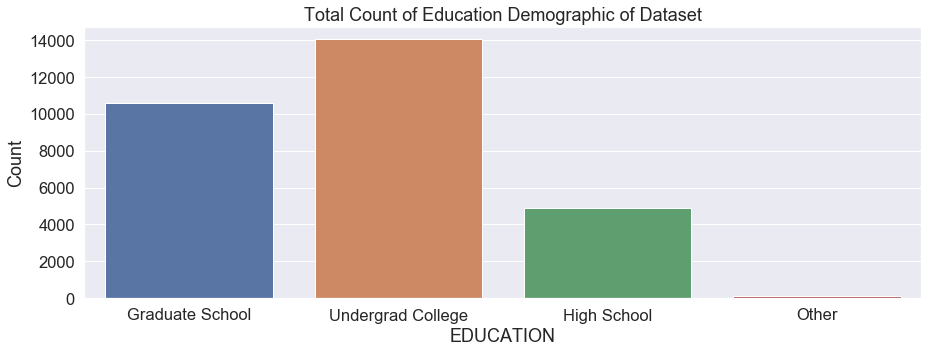

In [46]:
# Education distribution visualization

plt.figure(figsize=(15,5))

sns.set_style('darkgrid')
sns.set(font_scale = 1.5)

sns.countplot(x='EDUCATION', data=df)
plt.title('Total Count of Education Demographic of Dataset')
plt.ylabel('Count')
plt.xticks(range(0,4), ['Graduate School', 'Undergrad College', 'High School', 'Other'])
plt.show()

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


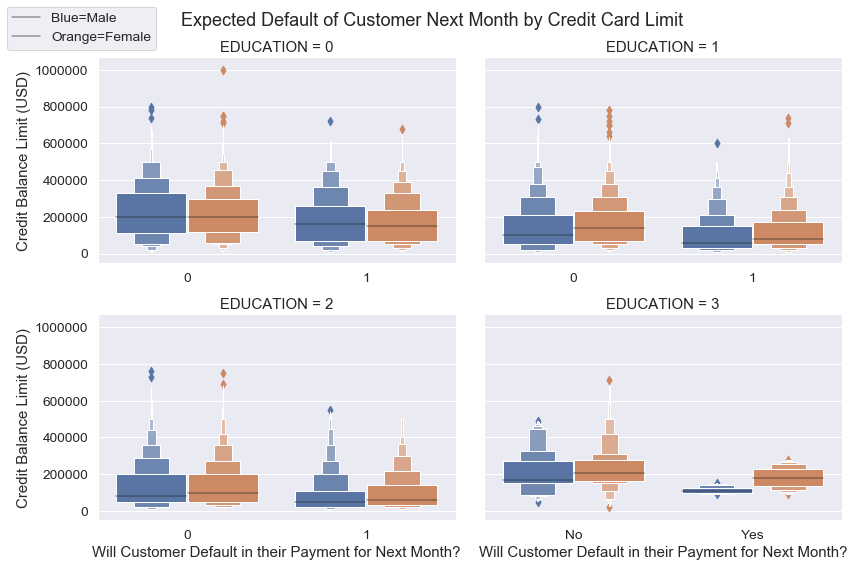

Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


In [41]:
# credit balance visualization

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', 
            col='EDUCATION', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=False, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Credit Card Limit')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Credit Balance Limit (USD)')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

---
---
### Marriage

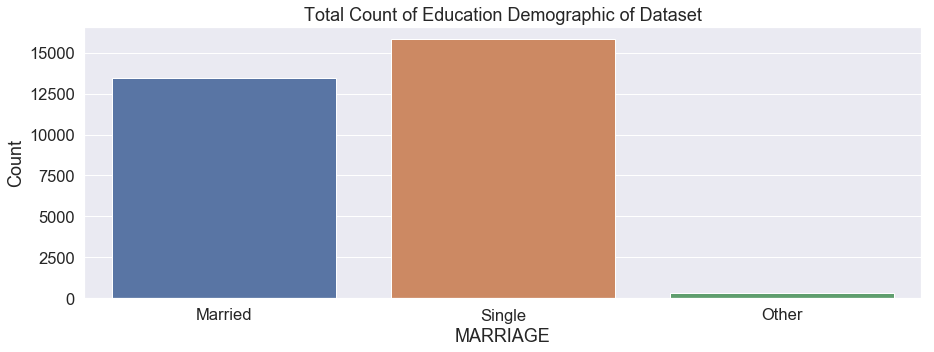

In [47]:
# Marriage distribution visualization

plt.figure(figsize=(15,5))

sns.set_style('darkgrid')
sns.set(font_scale = 1.5)

sns.countplot(x='MARRIAGE', data=df)
plt.title('Total Count of Education Demographic of Dataset')
plt.ylabel('Count')
plt.xticks(range(0,3), ['Married', 'Single', 'Other'])
plt.show()

C:\Anaconda\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


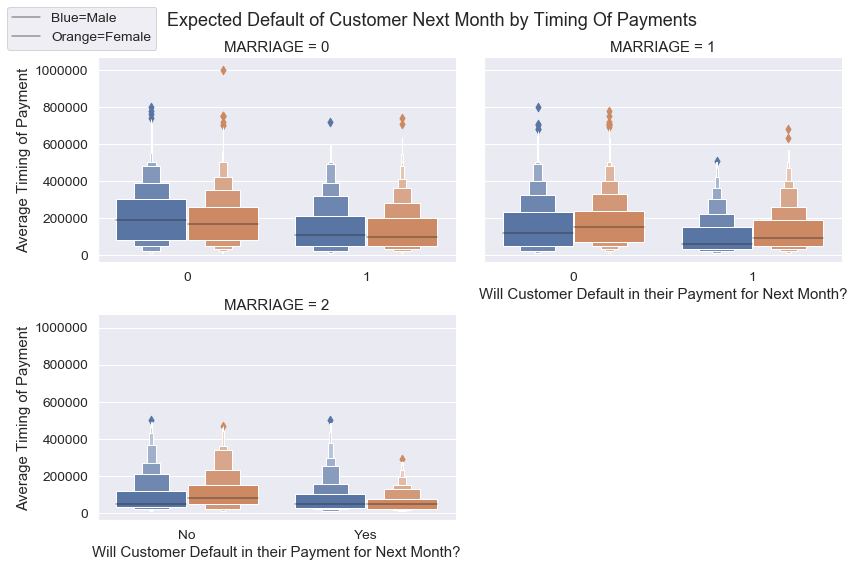

A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.
Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


In [42]:
# continued data visualization
# doing Category plot to see if timing of payment plays factor

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='LIMIT_BAL', hue='SEX', 
            col='MARRIAGE', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=False, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')
print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

---
---
### Age

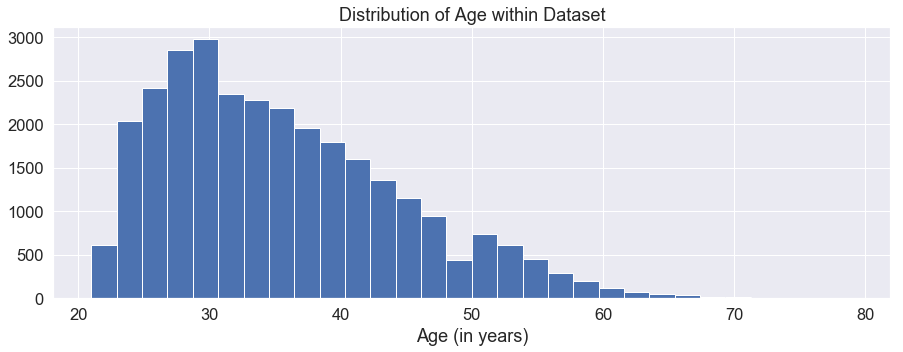

In [51]:
# Finally, AGE demographic
plt.figure(figsize=(15,5))

plt.hist(x=df.AGE, bins=30)
plt.title('Distribution of Age within Dataset')
plt.xlabel('Age (in years)')
plt.show()

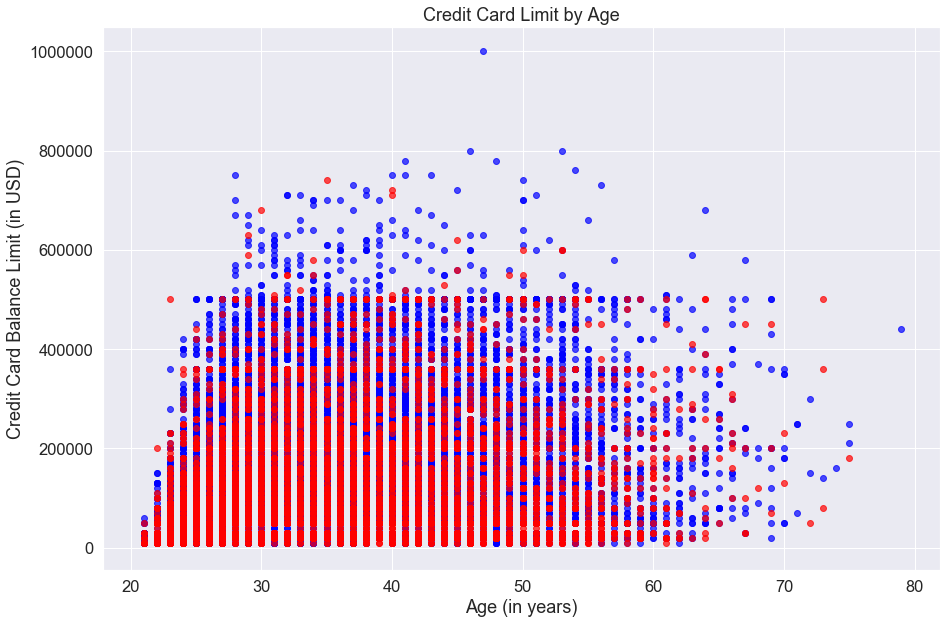

In [56]:
# looking at age for default/no default by age and credit limit
'''
Unlike above, age is ***continuous*** variable, 
so a scatterplot more appropriate than the above violin plots and
other distribution box plots that are apropos for categorical variables.
'''

agedefault = df[df['default payment next month'] == 1].copy()
agenodefault = df[df['default payment next month'] == 0].copy()

plt.figure(figsize=(15,10))

plt.scatter(x=agenodefault.AGE, y=agenodefault.LIMIT_BAL, alpha=0.7, color='blue')
plt.scatter(x=agedefault.AGE, y=agedefault.LIMIT_BAL, alpha=0.7, color='red')
plt.title('Credit Card Limit by Age')
plt.xlabel('Age (in years)')
plt.ylabel('Credit Card Balance Limit (in USD)')
plt.show()

### Brief Observation on "Credit Balance Limit"

Those individuals with lower credit balance limits (identified as `df.LIMIT_BAL`), regardless of sex, education, marriage, or age, defaulted in their credit card payment in the following month.  This observation suggests that a lower balance limit is a __result of__ other financial factors that ultimately contribute to the default, but the limit itself is NOT the cause. 

This result is indicative of us putting the analytical cart before the horse. In other words, we should first figure out which features explain the target variable of default/no default the best. Once we figure out a starting point, then we can look into those features more closely.

---
# Feature Selection and Feature Engineering

The above visualization analysis emphasizes an important point in machine learning: chucking the entire dataset into a model does not help the model. In other words, more data does __not__ equate to a more accurate result. Not only will having the model analyze more information slow down the model, some features may actually _detract_ from a better result.

To avoid this, we need to __select__ features. Moreover, it is common to create, or "engineer", features to enhance explanatory power. 

We will deal with feature selection first.

## Feature Selection

How does one find out which features are most important in correlating with and explaining the target variable? Furthermore, is there a way to identify the _extent_ which a given feature correlates and explains?

There are a number of feature selection techniques, each with their own emphases, pros, and cons. Below is a list of feature selection techniques used here:

1. LASSO regression combined with a "leave-one-out" method
2. `.feature_importance()` method used in tree models, such as a Random Forest Classifier.
2. Correlative heatmap
3. SHAP value analysis
4. Permutation importance
5. Partial Dependence Plot
6. Dependency Contribution Plot

Much like the order of analysis for feature visualization, if it is determined that there is a weak correlation between the features and the target variable, we will have to switch gears and perform feature engineering, _and then_ we will confirm that the added features will help by resuming out feature selection process.

---

### Feature Selection: LASSO Regression

LASSO regression is logistic regression with a L1 regularization penalty. __Logistic Regression__ is a regression analysis on the _probability_ that a datapoint will be characterized as falling in one category (1 or will default) over another (0 or will not default). In other words, while it is accurately defined as a regression analysis, it is used for categorical problems, such as this one here.

__L1 Regularization__ acts to penalize less important features, thus emphasizing the more important features (i.e., the features that are most correlated with the target variable). The LASSO penalty is effective with datasets that have a very large feature space.

As a feature selection, we will use a common "hold-one-out" method.* For this method, we will purposely take out a single feature and run the regression model. If the model's accuracy score drops significantly, we can conclude that the feature taken out is important to the model's analysis. The LASSO penalty will create a starker accuracy difference.

---
\*This is essentially how LASSO works: if the model works well enough without a feature, it will penalize that feature down to zero. However, this is all done on the backend; LASSO does not indicate _which_ features are being excluded. Therefore, a more explicit holdout method is employed.


In [57]:
# Warnings are annoying!

import warnings
warnings.filterwarnings(action='ignore')

In [58]:
# Setting X and Y for the model

# Using all numeric variables (including dummy'ed features)

X = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

Y = df['default payment next month']

In [63]:
# Final check - checking coefficient importances with LASSO regression (a feature selection method)

from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logistregr = LogisticRegression(penalty='l1', C=0.65) # C is the inverse of the strength of the penalty parameter 'lambda'

'''
Doing a hold-one-out method analysis (len(X.columns) - 1) times 
will take a while, hence cv only being 3.

Also, cross_val_score does the fitting for you, so no separate .fit line.
'''

# performing manual hold-one-out method
for dropped_column in X.columns:
    Xholdout = X.drop(columns=[dropped_column]) # holding out a single column
    print('\nR-squared WITHOUT column: ', dropped_column)
    print(cross_val_score(logistregr, Xholdout, Y, cv=3)) # performing cross-val analysis for each holdout


R-squared WITHOUT column:  LIMIT_BAL
[0.80512769 0.81250633 0.8072167 ]

R-squared WITHOUT column:  SEX
[0.80512769 0.81382386 0.80893979]

R-squared WITHOUT column:  EDUCATION
[0.80522902 0.81341847 0.80691263]

R-squared WITHOUT column:  MARRIAGE
[0.80431698 0.81250633 0.80883844]

R-squared WITHOUT column:  AGE
[0.80563437 0.81463464 0.80701399]

R-squared WITHOUT column:  PAY_0
[0.79296717 0.79243944 0.79434421]

R-squared WITHOUT column:  PAY_2
[0.8070531  0.81260768 0.8065072 ]

R-squared WITHOUT column:  PAY_3
[0.80472233 0.81473599 0.80914251]

R-squared WITHOUT column:  PAY_4
[0.80451966 0.81483734 0.80772349]

R-squared WITHOUT column:  PAY_5
[0.80492501 0.8141279  0.80802757]

R-squared WITHOUT column:  PAY_6
[0.80502635 0.81382386 0.80812893]

R-squared WITHOUT column:  BILL_AMT1
[0.80553304 0.81311442 0.80782485]

R-squared WITHOUT column:  BILL_AMT2
[0.80522902 0.81422925 0.80812893]

R-squared WITHOUT column:  BILL_AMT3
[0.80553304 0.8143306  0.80802757]

R-squared WITH

With the exception of the feature `PAY_0`, it does not appear any of the features are particularly important. Let's see if another feature selection method will identify standout features.

---
### Tree Feature Importances

__Decision tree__ models\* are non-parametric\** supervised learning models that create conditionals that split the data into diverging nodes at a lower layer of the tree. The splitting continues until it arrives at an answer (default or no default). Every split decreases _entropy_ (measurement of differences within the data) until it achieves homogeneity.

The beauty of decision trees is that the features it uses as the conditional statements that split the data is all determined on the backend. Sure, this "beauty" is more accurately characterized as a black box, but for purposes of feature importance, the tree directly __tells us__ which features it found to be important. No heavy lifting on the data scientist's end! We will find this feature importance using the `.feature_importance()` method of the tree.

---
\*The model that we are using, __Random Forest Classifier__, is an ensemble model that is a collection of decision trees, which are averaged (but not boosted). More modeling means higher accuracy, but higher accuracy could also suggest overfitting.

\*\*__Non-parametric__ means that the input data is not required to be normally distributed for the model to analyze accurately.

In [67]:
# importing relevant sklearn model 
from sklearn import ensemble

# model instantiation
rfc = ensemble.RandomForestClassifier(n_estimators=250, random_state=444)
'''
Some important default parameters used in this model:
bootstrap=True  :  also known as "bagging", trees are run in parallel, 
                   and their values are averaged for an overall result
                   
max_depth=None  :  No maximum amount of layers in the decision trees. 
                   Yields higher accuracy, but (1) more prone to overfitting, and 
                   (2) more computationally demanding
                   
min_impurity_decrease=0 : indicative that no minimum threshold for learning
min_impurity_split=0

criterion='gini': "Gini" coefficient, which is a measurement of variance/dispersion within a dataset
                  coefficient value of "0" means most accurate. It is an error measurement.
'''

# sample check for accuracy
# takes about 10 seconds due to higher # trees (default n_estimators==10)  
cross_val_score(rfc, X, Y, cv=5)

array([0.80391826, 0.80861486, 0.81790541, 0.82652027, 0.81790541])

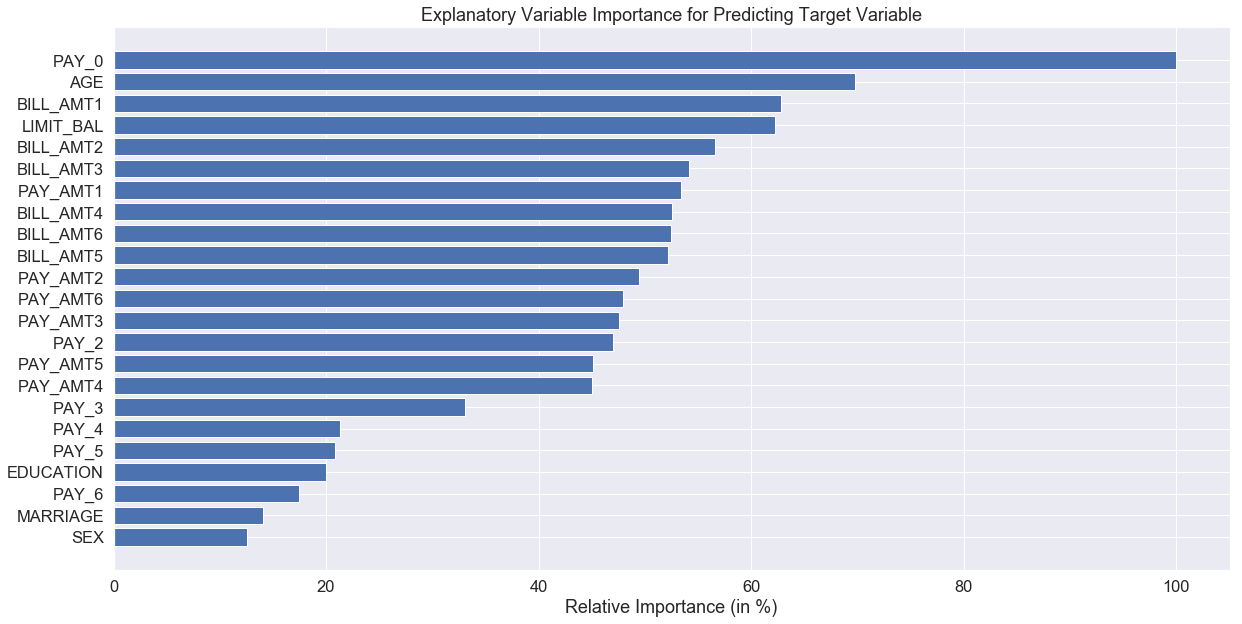

In [68]:
# checking feature importance derived from this model

# never officially fit the model 
#(done automatically via cross_val_score but need to explicitly do here)
rfc.fit(X,Y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('Explanatory Variable Importance for Predicting Target Variable')
plt.show()

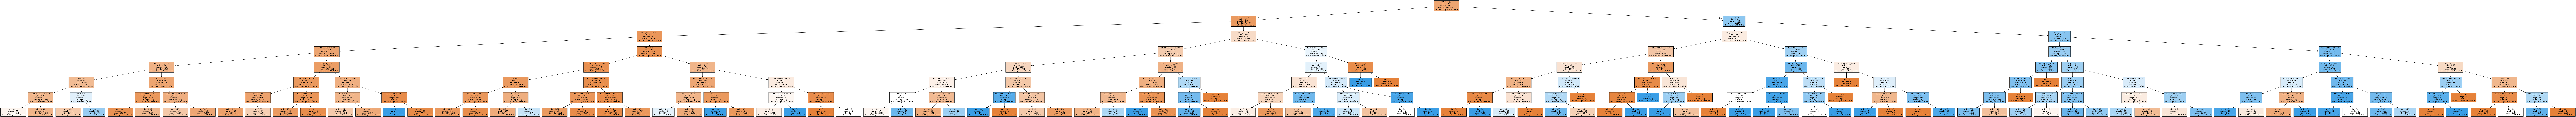

In [70]:
# graphing **sample** decision tree for a visual reference for determining relative importance

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=7, # wanted to do 10 but simply can't fit it here
)
decision_tree.fit(X, Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not Expected to Default', 'Expected to Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
treeimage = Image(graph.create_png())

treeimage

In [71]:
print("The accuracy of this decision tree's results are {}%.".format(decision_tree.score(X, Y))) # somewhat accurate using all the data

The accuracy of this decision tree's results are 0.8284517414952197%.


In [79]:
# saving the image in case something happens
graph.write_png('D:/Github/Data-Science-Bootcamp/CAPSTONE - Supervised Learning/CAPSTONE-Supervised_Learning/tree_image.png')


True

#### Two Notes on this Sample Decision Tree

1. The initial output displays the entire tree, i.e., in very small font. In Jupyter Notebook, you can double click on the tree to enlarge the image.

2. Analysis-wise, this decision tree blurb supports the random forest feature importance measurement - critical determinations at the upper nodes were made via PAY_0, BILL_AMT1, and LIMIT_BAL, as some examples. Just noting for reasons of feature importance analysis.

### Feature Importance Analysis

Judging from our feature importances derived from our Random Forest, it appears that the _individual_ features do not yield explanatory power. As seen before, AGE very mildly explains the variance. 

The one other feature that significant relative\* importance is `PAY_0`. This feature shows the timing of a credit card payment for the month before the month that is being measured as default or not default. Of course, if the person fails to pay the credit card on the month before (or pays it late), this would obviously be a highly important feature.

However, the circumstances of PAY_0 are highly specific to the dataset - this dataset measures a specific six-month period. It would not be a predictive indicator of whether other debtors will default.

---
\*It is important to emphasize that the feature importance graph compares _relative_ importances. It does not suggest that PAY_0 100% directly explains the target variable. It means that it was the most important, and the importances of all other features are compared to to the importance of PAY_0 (hence the "relative-ness" of the graph). In essence, that graph does __not__ indicate just how important _any_ of the features are.

---
## Feature Engineering

a

In [81]:
ff = 'whasdadsada'

str('{}'.format(ff))

'whasdadsada'

### Feature Importance Analysis

When analyzing the the individual items of timing of payment, the individual bill amount for each month, and the individual payment amount by the customer for each month, the relative importances barely eclipse 60%.^^ However, when aggregating each of these data categories into single averaged columns, relative importance jumps up to over 95% importance.  

Therefore, for now, we will be working with the aggregated columns.
***
^^ Two items surpassed the 60% mark according to the first relative importance bar chart - PAY_O and BILL_AMT1. This is not surprising, as those columns reflect the most recent status of the customer's financial position and therefore are highly biased in estimating what will happen in the following month (as opposed to, say, data from five months ago). While this works here, it is not appropriate to use those two columns of data in a vacuum. This high bias will not translate well to newer data to be applied to the model.

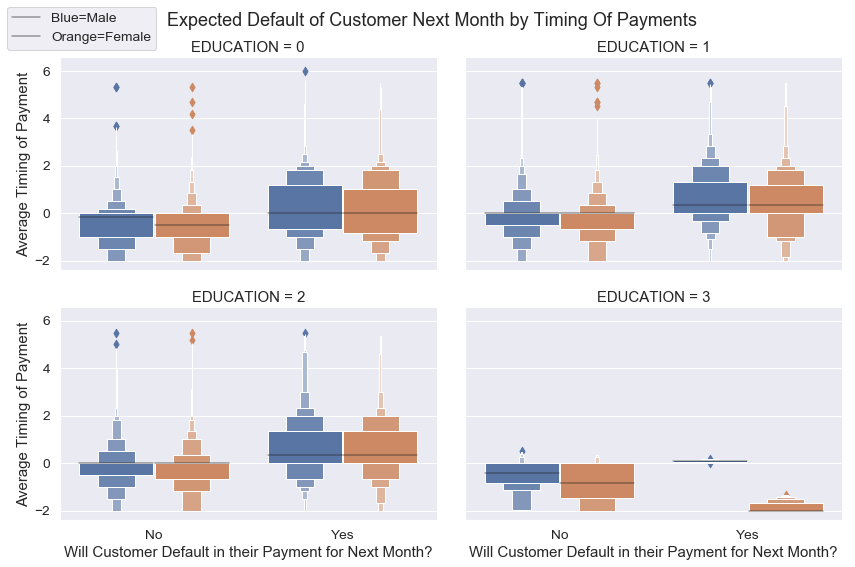

A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.
Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:'Other'}


In [249]:
# continued data visualization
# doing Category plot to see if timing of payment plays factor

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='payment timing avg', hue='SEX', 
            col='EDUCATION', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=True, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')
print('Education: {0:Graduate School, 1:Undergraduate, 2:High School, 3:\'Other\'}')

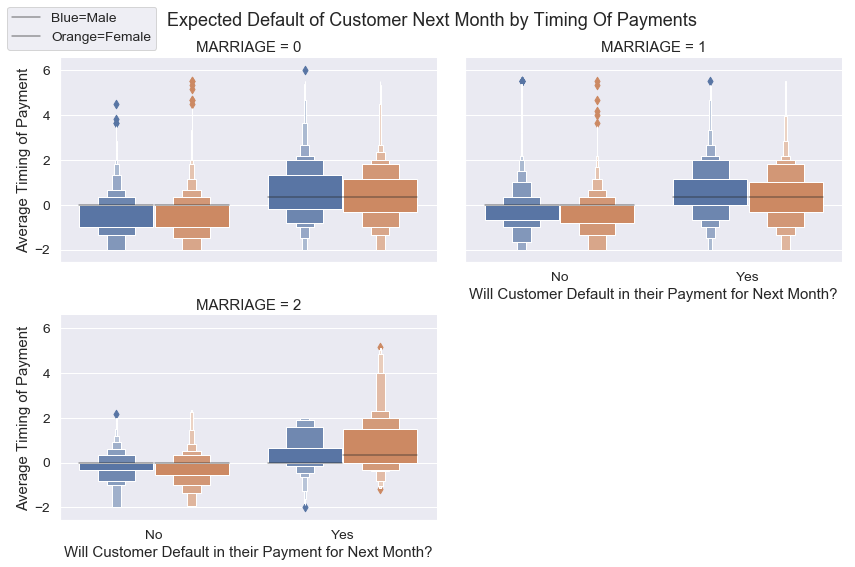

A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.


In [254]:
# continued data visualization
# doing Category plot to see if timing of payment plays factor

sns.set_style('darkgrid')
sns.set(font_scale = 1.25)

g = sns.catplot(x='default payment next month', y='payment timing avg', hue='SEX', 
            col='MARRIAGE', data=df, kind='boxen', 
            col_wrap=2, aspect=1.5, legend=False, sharex=True, sharey=True, size=4)


g.fig.suptitle('Expected Default of Customer Next Month by Timing Of Payments')
g.fig.subplots_adjust(top=.9)
g.fig.legend(labels=['Blue=Male', 'Orange=Female'], loc='upper left')

g.set_ylabels('Average Timing of Payment')
g.set_xlabels('Will Customer Default in their Payment for Next Month?')
plt.xticks(ticks=range(0,2), labels=['No', 'Yes'])
plt.show()

print('A Positive number Shows That Many Months **PAST** the Due Date for a Bill Statement.')

In [21]:
# Creating new aggregated columns

df['payment timing avg'] = (df.PAY_0 + df.PAY_2 + df.PAY_3 + df.PAY_4 + df.PAY_5 + df.PAY_6) / 6

In [22]:
# I want to see if this makes any difference if I average the columns
df['bill amount avg.'] = (df.BILL_AMT1 + df.BILL_AMT2 + df.BILL_AMT3 + df.BILL_AMT4 + df.BILL_AMT5 + df.BILL_AMT6) / 6
df['pay amount avg.'] = (df.PAY_AMT1 + df.PAY_AMT2 + df.PAY_AMT3 + df.PAY_AMT4 + df.PAY_AMT5 + df.PAY_AMT6) / 6
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    1          1         0   24      2      2     -1     -1   
1   2     120000    1          1         1   26     -1      2      0      0   
2   3      90000    1          1         1   34      0      0      0      0   
3   4      50000    1          1         0   37      0      0      0      0   
4   5      50000    0          1         0   57     -1      0     -1      0   

        ...         PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0       ...                0       689         0         0         0   
1       ...                0      1000      1000      1000         0   
2       ...             1518      1500      1000      1000      1000   
3       ...             2000      2019      1200      1100      1069   
4       ...             2000     36681     10000      9000       689   

   PAY_AMT6  default payment next month  payment timing avg  bill amount avg.  \
0         0                           1           -0.333333       1284.000000   
1      2000                           1            0.500000       2846.166667   
2      5000                           0            0.000000      16942.166667   
3      1000                           0            0.000000      38555.666667   
4       679                           0           -0.333333      18223.166667   

   pay amount avg.  
0       114.833333  
1       833.333333  
2      1836.333333  
3      1398.000000  
4      9841.500000  

[5 rows x 28 columns]

In [25]:
# New X
X1 = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'payment timing avg', 'bill amount avg.', 'pay amount avg.']]

In [26]:
# Re-doing random forest for feature importance with new X
rfc = ensemble.RandomForestClassifier(n_estimators=50)
cross_val_score(rfc, X1, Y, cv=20)

array([0.78663065, 0.78528022, 0.79473329, 0.79945982, 0.79675895,
       0.79121622, 0.79324324, 0.78716216, 0.79324324, 0.79932432,
       0.8027027 , 0.81418919, 0.81418919, 0.79391892, 0.81418919,
       0.78986486, 0.8025693 , 0.79986477, 0.80797836, 0.79175118])

In [28]:
print('The above cross-validated scores contain the newly engineered features.')
print('These scores can be contrasted with the original feature space shown below.')

cross_val_score(rfc, X, Y, cv=20)

The above cross-validated scores contain the newly engineered features.
These scores can be contrasted with the original feature space shown below.


array([0.80081026, 0.80621202, 0.79135719, 0.80688724, 0.81498987,
       0.80675676, 0.80540541, 0.80202703, 0.81418919, 0.80743243,
       0.81418919, 0.82364865, 0.83243243, 0.81351351, 0.83040541,
       0.81418919, 0.82014875, 0.82488168, 0.81000676, 0.81203516])

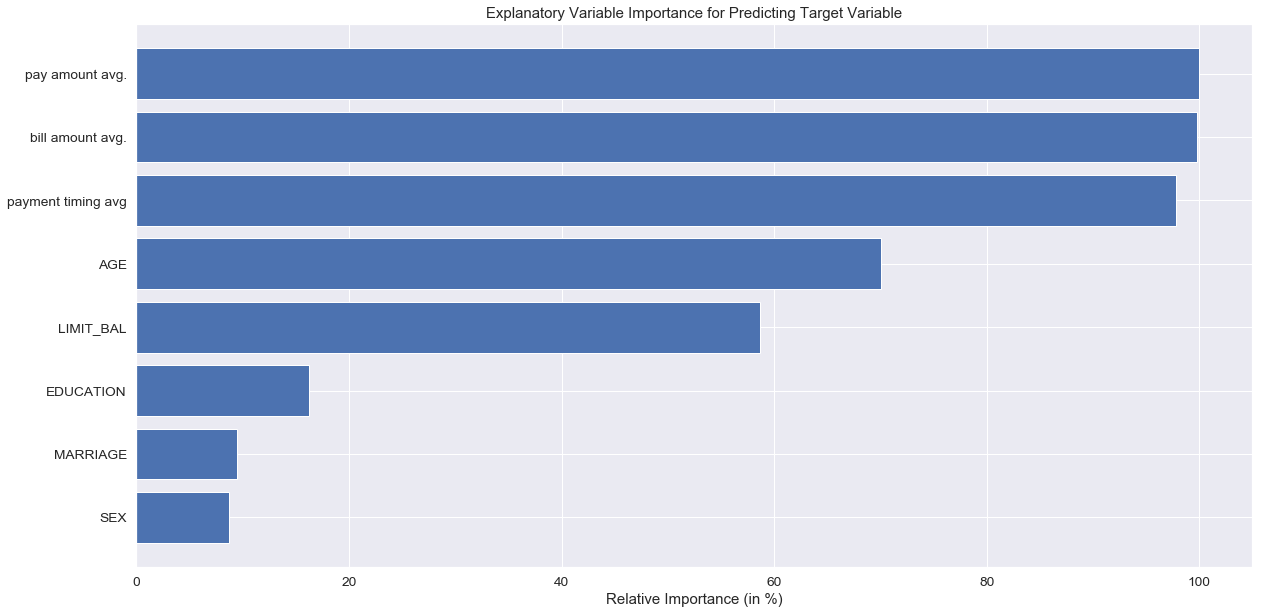

In [29]:
# re-fitting and measuring

rfc.fit(X1, Y)
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('Explanatory Variable Importance for Predicting Target Variable')
plt.show()

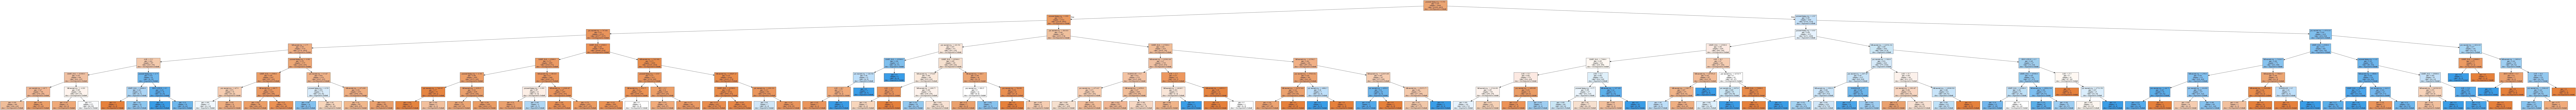

In [30]:
# Doing another tree

X1columnnames = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'payment timing avg', 'bill amount avg.', 'pay amount avg.']

decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=7, 
)
decision_tree.fit(X1, Y)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X1columnnames,
    class_names=['Not Expected to Default', 'Expected to Default'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [31]:
print("The accuracy of this decision tree is {}%.".format(decision_tree.score(X1, Y)))

The accuracy of this decision tree is 0.8142968142968143%.


---

---

In [41]:
# going to do more feature engineering - 
# the aggregation columns didn't help all that much (they even hurt the score a little bit)

# looking at only pay_amt and bill_amt - features high on original feature importance graph

df_bill_and_pay = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'bill amount avg.',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'pay amount avg.', 
                     'default payment next month']].copy()
df_bill_and_pay.head()

BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
0       3913       3102        689          0          0          0   
1       2682       1725       2682       3272       3455       3261   
2      29239      14027      13559      14331      14948      15549   
3      46990      48233      49291      28314      28959      29547   
4       8617       5670      35835      20940      19146      19131   

   bill amount avg.  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
0       1284.000000         0       689         0         0         0   
1       2846.166667         0      1000      1000      1000         0   
2      16942.166667      1518      1500      1000      1000      1000   
3      38555.666667      2000      2019      1200      1100      1069   
4      18223.166667      2000     36681     10000      9000       689   

   PAY_AMT6  pay amount avg.  default payment next month  
0         0       114.833333                           1  
1      2000       833.333333                           1  
2      5000      1836.333333                           0  
3      1000      1398.000000                           0  
4       679      9841.500000                           0

In [81]:
# checking if payments make a difference
df_bill_and_pay_investigate3 = df_bill_and_pay[(df_bill_and_pay['PAY_AMT1'] != 0) & 
                                              (df_bill_and_pay['PAY_AMT2'] != 0) & (df_bill_and_pay['PAY_AMT3'] != 0) & 
                                              (df_bill_and_pay['PAY_AMT4'] != 0) & (df_bill_and_pay['PAY_AMT5'] != 0) & 
                                              (df_bill_and_pay['PAY_AMT6'] != 0)].copy()

df_bill_and_pay_investigate3.head(20)

BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
2       29239      14027      13559      14331      14948      15549   
3       46990      48233      49291      28314      28959      29547   
4        8617       5670      35835      20940      19146      19131   
5       64400      57069      57608      19394      19619      20024   
6      367965     412023     445007     542653     483003     473944   
10      11073       9787       5535       2513       1828       3731   
14      70887      67060      63561      59696      56875      55512   
17     253286     246536     194663      70074       5856     195599   
20      38358      27688      24489      20616      11802        930   
25      47620      41810      36023      28967      29829      30046   
27      22541      16138      17163      17878      18931      19617   
31      30518      29618      22102      22734      23217      23680   
32      93036      84071      82880      80958      78703      75589   
33      10929       4152      22722       7521      71439       8981   
36     186503     181328     180422     170410     173901     177413   
40     218668     221296     206895     628699     195969     179224   
41      67521      66999      63949      63699      64718      65970   
42       1877       3184       6003       3576       3670       4451   
43      59504      61544      62925      64280      67079      69802   
48      22401      21540      15134      32018      11849      11873   

    bill amount avg.  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  \
2       16942.166667      1518      1500      1000      1000      1000   
3       38555.666667      2000      2019      1200      1100      1069   
4       18223.166667      2000     36681     10000      9000       689   
5       39685.666667      2500      1815       657      1000      1000   
6      454099.166667     55000     40000     38000     20239     13750   
10       5744.500000      2306        12        50       300      3738   
14      62265.166667      3000      3000      3000      3000      3000   
17     161002.333333     10358     10000     75940     20000    195599   
20      20647.166667      3000      1537      1000      2000       930   
25      35715.833333      1973      1426      1001      1432      1062   
27      18711.333333      1300      1300      1000      1500      1000   
31      25311.500000      1718      1500      1000      1000      1000   
32      82539.500000      3023      3511      3302      3204      3200   
33      20957.333333      4152     22827      7521     71439       981   
36     178329.500000      8026      8060      6300      6400      6400   
40     275125.166667     10000      7000      6000    188840     28000   
41      65476.000000      3000      4500      4042      2500      2800   
42       3793.500000      1500      2927      1000       300      1000   
43      64189.000000      3000      3000      3000      4000      4000   
48      19135.833333     21540     15138     24677     11851     11875   

    PAY_AMT6  pay amount avg.  default payment next month  \
2       5000      1836.333333                           0   
3       1000      1398.000000                           0   
4        679      9841.500000                           0   
5        800      1295.333333                           0   
6      13770     30126.500000                           0   
10        66      1078.666667                           0   
14      3000      3000.000000                           0   
17     50000     60316.166667                           0   
20     33764      7038.500000                           0   
25       997      1315.166667                           0   
27      1012      1185.333333                           0   
31       716      1155.666667                           1   
32      2504      3124.000000                           0   
33     51582     26417.000000                           0   
36      6737      698

In [83]:
df_bill_and_pay_investigate3['default payment next month'].value_counts() # a good feature!

0    13103
1     2135
Name: default payment next month, dtype: int64

In [158]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'payment timing avg', 'bill amount avg.',
       'pay amount avg.', 'bill paid to bill total ratio',
       'Consistent Payment?', 'Faster Payor'],
      dtype='object')

In [206]:
consistent_payment = []

for s, t, u, v, w, y, a, b, c, d, e, f in zip(df['BILL_AMT1'], df['BILL_AMT2'], df['BILL_AMT3'], 
                                              df['BILL_AMT4'], df['BILL_AMT5'], df['BILL_AMT6'],
                                              df['PAY_AMT1'], df['PAY_AMT2'], df['PAY_AMT3'], 
                                              df['PAY_AMT4'], df['PAY_AMT5'], df['PAY_AMT6']):
    billamt = s + t + u + v + w + y
    payamt = a + b + c + d + e + f
    if billamt != 0 and payamt != 0:
        consistent_payment.append(0)
    
    elif billamt == 0 and payamt == 0: # making sure there is no flag for instances where the balance is zero
        consistent_payment.append(0)
        
    else:
        consistent_payment.append(1) # i.e., not a consistent payment
         

df['Consistent Payment?'] = pd.Series(consistent_payment)

In [207]:
# added this ratio feature to the wrong dataframe
df['bill paid to bill total ratio'] = df['pay amount avg.'] / df['bill amount avg.']

In [214]:
faster_payor = []
for i, j, k, l, m, n in zip(df['PAY_0'], df['PAY_2'], df['PAY_3'], df['PAY_4'], df['PAY_5'], df['PAY_6']):
    
    all_zero = ((i == 0) & (j == 0) & (k == 0) & (l == 0) & (m == 0) & (n == 0))
    all_same = ((i == j) & (j == k) & (k == l) & (l == m) & (m == n) & ~all_zero)
    
    if all_zero:
        faster_payor.append(1)
    elif all_same: # has to be *some* improvement
        faster_payor.append(0)
    elif ((i >= j) & (j >= k) & (k >= l) & (l >= m) & (m >= n) & all_same is False):
        faster_payor.append(1)
    else:
        faster_payor.append(0)

df['Faster Payor'] = pd.Series(faster_payor)
        
df.tail(5)        

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
29995  29996     220000    0          2         0   39      0      0      0   
29996  29997     150000    0          2         1   43     -1     -1     -1   
29997  29998      30000    0          1         1   37      4      3      2   
29998  29999      80000    0          2         0   41      1     -1      0   
29999  30000      50000    0          1         0   46      0      0      0   

       PAY_4                        ...                          PAY_AMT6  \
29995      0                        ...                              1000   
29996     -1                        ...                                 0   
29997     -1                        ...                              3100   
29998      0                        ...                              1804   
29999      0                        ...                              1000   

       default payment next month  \
29995                           0   
29996                           0   
29997                           1   
29998                           1   
29999                           1   

                                      payment timing avg  \
29995                                               0.00   
29996                                              -0.67   
29997                                               1.33   
29998                                              -0.17   
29999                                               0.00   

                                        bill amount avg.  \
29995                                         120,891.50   
29996                                           3,530.33   
29997                                          11,749.33   
29998                                          44,435.17   
29999                                          38,479.00   

                                         pay amount avg.  \
29995                                           7,091.67   
29996                                           2,415.00   
29997                                           5,216.67   
29998                                          24,530.17   
29999                                           1,384.67   

                           bill paid to bill total ratio  \
29995                                               0.06   
29996                                               0.68   
29997                                               0.44   
29998                                               0.55   
29999                                               0.04   

                                     Consistent Payment?  \
29995                                                nan   
29996                                                nan   
29997                                                nan   
29998                                                nan   
29999                                                nan   

                                            Faster Payor  \
29995                                                nan   
29996                                                nan   
29997                                                nan   
29998                                                nan   
29999                                                nan   

                                 Consistent Late Payment  \
29995                                                nan   
29996                                                nan   
29997                                                nan   
29998                                                nan   
29999                                                nan   

                                      Very Late Payment?  
29995                                                nan  
29996                                                nan  
29997                                                nan  
29998                                                nan  
29999                      

In [209]:
# Final feature - !paying!
dfrolling = df.iloc[:, 6:12] # creating the rolling function dataset
dfrolling['default payment'] = df['default payment next month']
dfrolling.loc[1460:1500, :]


PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  default payment
1460      2      2      3      3      3      3                1
1461      0      0      2      0      0      2                0
1462      0      0      0      0      0      0                0
1463     -1     -1     -1      0      0      0                0
1464     -1      0      0      0      0      0                0
1465      0      0      0      0      0      0                0
1467     -1     -1     -1     -1      0     -1                0
1468     -1     -1     -1     -2     -2     -2                0
1469      1     -2     -2     -2     -2     -2                1
1470      0      0      0      0      0      0                0
1471      0      0      2      0      0     -2                1
1472      0      0     -1      0      0      0                0
1473     -1     -1     -1     -1     -1     -1                0
1474      0      0      0      0      0      0                1
1475      0      0      0      0      0      0                0
1476     -1     -1      0      0      0      0                0
1477      0      0      0      0      0      0                0
1478      1     -2     -2     -2     -1     -1                1
1479      1     -2     -1      0     -1     -1                0
1480      0      0      0     -1     -1      0                0
1481      0      0      0      0      0     -2                0
1482      0      0      0      0      0      0                0
1483     -1     -1     -1     -1     -1     -1                0
1484      0      0      0      0      0      0                0
1485      2      2      7      7      7      6                1
1486      0      0      0      0      0      0                0
1487      0      0      0      0      0     -1                0
1488      3      2      2      0      0      0                1
1489      0      0      2      2      2      2                1
1490      0      0      0      0      0      0                0
1491      0      0      0      0      0      0                0
1492      2      0      0      0      0      0                0
1493     -1     -1      0      0      0     -1                0
1494      0     -1     -1      0     -1      0                0
1495      2      2      2      0      0      0                0
1496      2      2      2      0      0      0                1
1497      0      0      0      2      0      0                0
1498      1     -1     -1     -1     -1     -1                0
1499      1      2     -1     -1      0      0                0
1500      0      0      0      0      0      0                0

In [210]:
# rolling window feature - if three consecutive columns total a positive number, that means on average, the person pays late
# paying late is a feature to be correlated with target variable

dfrollingcount = dfrolling.rolling(3, axis=1).sum() # rolling window calculation done here

rolltest = []

for i, j, k, l in zip(dfrollingcount['PAY_3'], dfrollingcount['PAY_4'], dfrollingcount['PAY_5'], dfrollingcount['PAY_6']):
    
    
    if ((i > 1) | (j > 1) | (k > 1) | (l > 1)): # 0 or 1 would be too little
        rolltest.append(1)
    else:
        rolltest.append(0)
        
df['Consistent Late Payment'] = pd.Series(rolltest)
        

In [211]:
verylatepayment = []

for i, j, k, l, m, n in zip(df['PAY_0'], df['PAY_2'], df['PAY_3'], df['PAY_4'], df['PAY_5'], df['PAY_6']):
    if ((i > 3) | (j > 3) | (k > 3) | (l > 3) | (m > 3) | (n > 3)):
        verylatepayment.append(1)
    else:
        verylatepayment.append(0)
        
df['Very Late Payment?'] = pd.Series(verylatepayment)

### Testing out the New Features

Let's take a look at a heatmap identifying the correlations between chosen features and the outcome variable. There, we can determine if the engineered features provide additional explanatory power.

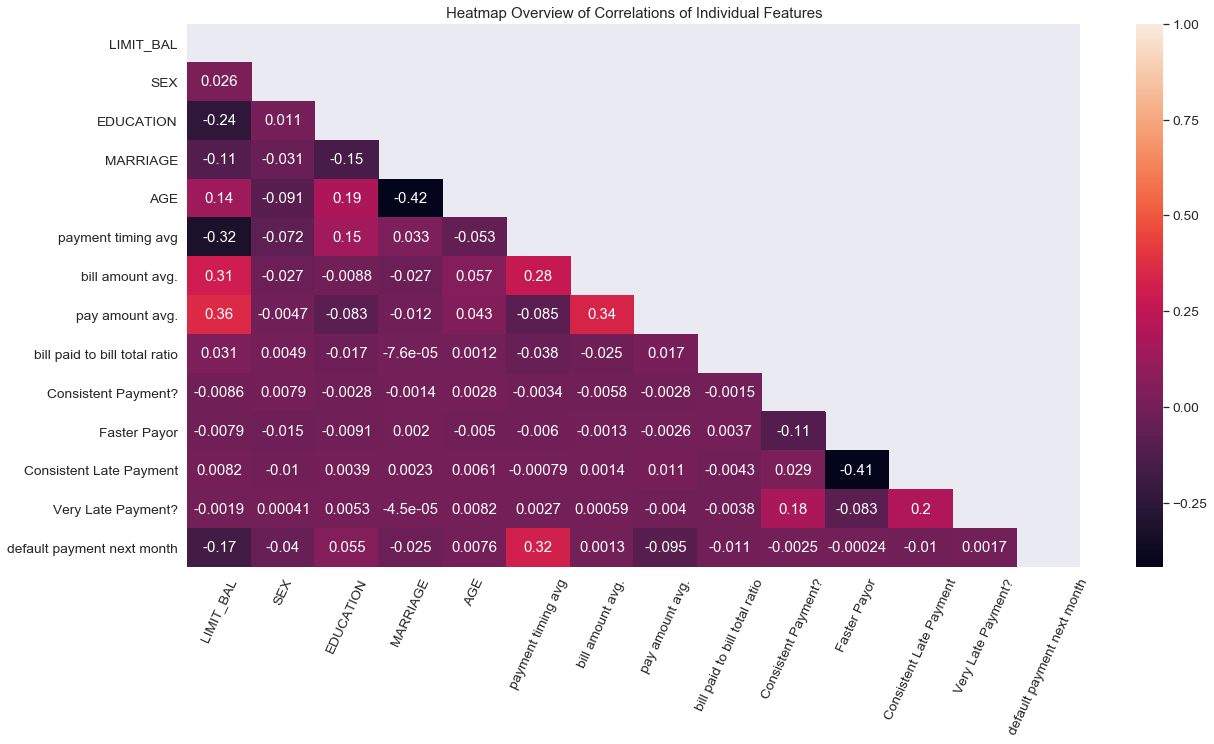

In [197]:
feature_corr_list = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'payment timing avg', 'bill amount avg.',
       'pay amount avg.', 'bill paid to bill total ratio',
       'Consistent Payment?', 'Faster Payor', 'Consistent Late Payment', 'Very Late Payment?',
                       'default payment next month']]

feature_corr = feature_corr_list.corr()

mask = np.zeros_like(feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,10))
ax = sns.heatmap(feature_corr, mask=mask, xticklabels=feature_corr_list.columns, 
                 yticklabels=feature_corr_list.columns, annot=True)

ax.set_xticklabels(labels=feature_corr_list.columns, rotation=65)

plt.title('Heatmap Overview of Correlations of Individual Features')

plt.show()

In [212]:
# going to check feature importances via a tree-based method
# will be unable to do it if there are NaN's in my dataset (will get ValueError if I do)

# checking if NaN's exist
columnsdf = list(df)

for i in columnsdf:
    print(i, df[i].isna().sum())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 485
Consistent Payment? 678
Faster Payor 678
Consistent Late Payment 678
Very Late Payment? 678


In [215]:
dfcheck = df[df.isna().any(axis=1)]
dfcheck.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
18    19     360000    1          0         0   49      1     -2     -2   
19    20     180000    1          0         1   29      1     -2     -2   
122  123     110000    1          0         0   48      1     -2     -2   
125  126      20000    0          1         1   23      1     -2     -2   
368  369     300000    0          0         0   40      1     -2     -2   

     PAY_4                        ...                          PAY_AMT6  \
18      -2                        ...                                 0   
19      -2                        ...                                 0   
122     -2                        ...                                 0   
125     -2                        ...                                 0   
368     -2                        ...                                 0   

     default payment next month  \
18                            0   
19                            0   
122                           0   
125                           0   
368                           0   

                                    payment timing avg  \
18                                               -1.50   
19                                               -1.50   
122                                              -1.50   
125                                              -1.50   
368                                              -1.50   

                                      bill amount avg.  \
18                                                0.00   
19                                                0.00   
122                                               0.00   
125                                               0.00   
368                                               0.00   

                                       pay amount avg.  \
18                                                0.00   
19                                                0.00   
122                                               0.00   
125                                               0.00   
368                                               0.00   

                         bill paid to bill total ratio  \
18                                                 nan   
19                                                 nan   
122                                                nan   
125                                                nan   
368                                                nan   

                                   Consistent Payment?  \
18                                                0.00   
19                                                0.00   
122                                               0.00   
125                                               0.00   
368                                               0.00   

                                          Faster Payor  \
18                                                0.00   
19                                                0.00   
122                                               1.00   
125                                               0.00   
368                                               1.00   

                               Consistent Late Payment  \
18                                                0.00   
19                                                0.00   
122                                               0.00   
125                                               0.00   
368                                               0.00   

                                    Very Late Payment?  
18                                                0.00  
19                                                0.00  
122                                               0.00  
125                                               0.00  
368                                               0.00  

[5 rows x 33 columns]

In [216]:
# There is no reason for these features to contain NaN's
# I can impute bill-paid-bill-total-ratio NaN values, as I know why those are NaN's (0/0 error)
# As for the rest, I unfortunately will have to drop those values.

replaced = {'bill paid to bill total ratio': 0}
df.fillna(value=replaced, inplace=True)

In [217]:
# checking how that affected NaN's in df
columnsdf = list(df)

for i in columnsdf:
    print(i, df[i].isna().sum())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 0
Consistent Payment? 678
Faster Payor 678
Consistent Late Payment 678
Very Late Payment? 678


In [224]:
# unfortunately dropping the rest...

df.dropna(inplace=True)
columnsdf = list(df)

for i in columnsdf:
    print(i, df[i].isna().sum())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 0
Consistent Payment? 0
Faster Payor 0
Consistent Late Payment 0
Very Late Payment? 0


In [229]:
# have to check again for infinites...

for i in columnsdf:
    print(i, np.isinf(df[i]).sum()) # 74 bad ones!

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 74
Consistent Payment? 0
Faster Payor 0
Consistent Late Payment 0
Very Late Payment? 0


In [230]:
dfcheck = df[np.isinf(df).any(axis=1)]
dfcheck.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
294    295     130000    0          0         1   29      1     -2     -2   
301    302     440000    1          0         1   36     -2     -2     -2   
604    605     180000    1          1         1   31      1     -2     -2   
1157  1158     470000    0          2         0   39      1     -2     -2   
2634  2635     200000    1          0         0   42     -2     -2     -2   

      PAY_4                        ...                          PAY_AMT6  \
294      -2                        ...                              1500   
301      -2                        ...                                 0   
604      -2                        ...                              1576   
1157     -2                        ...                               789   
2634     -2                        ...                               665   

      default payment next month  \
294                            0   
301                            0   
604                            0   
1157                           0   
2634                           1   

                                     payment timing avg  \
294                                               -1.50   
301                                               -2.00   
604                                               -1.50   
1157                                              -1.50   
2634                                              -2.00   

                                       bill amount avg.  \
294                                                0.00   
301                                                0.00   
604                                                0.00   
1157                                               0.00   
2634                                               0.00   

                                        pay amount avg.  \
294                                              250.00   
301                                           27,000.00   
604                                              262.67   
1157                                             131.50   
2634                                             110.83   

                          bill paid to bill total ratio  \
294                                                 inf   
301                                                 inf   
604                                                 inf   
1157                                                inf   
2634                                                inf   

                                    Consistent Payment?  \
294                                                0.00   
301                                                0.00   
604                                                0.00   
1157                                               0.00   
2634                                               0.00   

                                           Faster Payor  \
294                                                0.00   
301                                                1.00   
604                                                0.00   
1157                                               0.00   
2634                                               1.00   

                                Consistent Late Payment  \
294                                                0.00   
301                                                0.00   
604                                                0.00   
1157                                               0.00   
2634                                               0.00   

                                     Very Late Payment?  
294                                                0.00  
301                                                0.00  
604                                                0.00  
1157                                               0.00  
2634                                               0.00  

[5 rows x 33 columns]

In [233]:
print(len(df))
print(len(dfcheck))
dfcheck = df.drop(labels=df[np.isinf(df).any(axis=1)].index, axis=0)
print(len(dfcheck))

28624
74
28550


In [234]:
# that was a sample drop - didn't want to ruin my original dataset
# Now I'm actually dropping those values
df.drop(labels=df[np.isinf(df).any(axis=1)].index, axis=0, inplace=True)

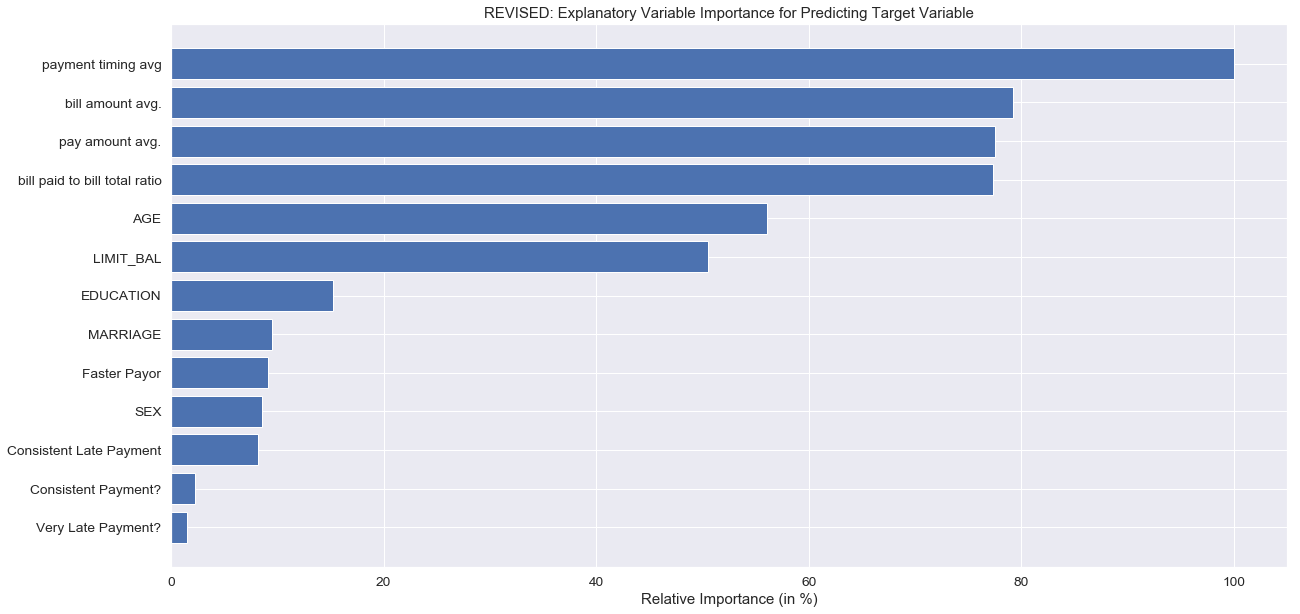

In [235]:
# Moving onto feature importances with df accounting for aggregated features
# checking this with tree-based importance determination

X = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'payment timing avg', 'bill amount avg.',
       'pay amount avg.', 'bill paid to bill total ratio',
       'Consistent Payment?', 'Faster Payor', 'Consistent Late Payment', 'Very Late Payment?']].copy()
Y = df['default payment next month']

rfc = ensemble.RandomForestClassifier(n_estimators=50)
rfc.fit(X, Y)

feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,10))

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (in %)')
plt.title('REVISED: Explanatory Variable Importance for Predicting Target Variable')
plt.show()

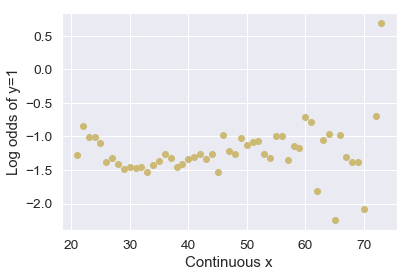

In [272]:
# transform it to log for more linearity
# Natural log of the odds.
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

plt.show()

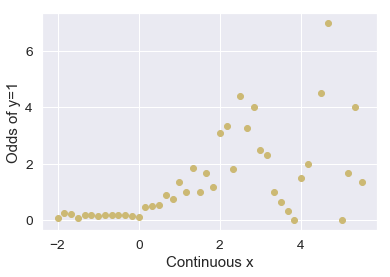

In [273]:
# Doing FINAL Correlation check
# Via logistic regression graphing

# setting variables
x = X['payment timing avg']
bin_y = Y

# Find the unique values of x
xvals = x.unique()

# Calculate and store the odds.
yodds = []

for xi in xvals: 
    y1_ct = bin_y[x == xi].sum()  # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

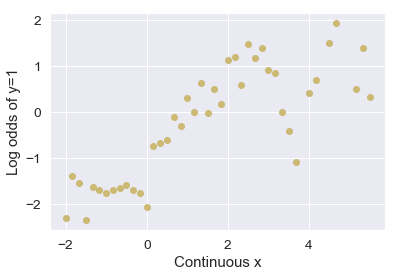

In [274]:
# transform it to log for more linearity
# Natural log of the odds.
ln_yodds = np.log(yodds)

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, ln_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Log odds of y=1')

plt.show()

In [ ]:
# Via logistic regression graphing

# Find the unique values of x
xvals = X['AGE'].unique()

# setting variables
x = X['AGE']
bin_y = Y

# Calculate and store the odds.
yodds = []

for xi in xvals: 
    y1_ct = bin_y[x == xi].sum()  # The number of trials y = 1.
    y0_ct = len(bin_y[x == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
    
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

## Looking at Default Payment Datapoints where Payment Balance is Zero

It is unclear how 299 rows of creditors having a zero balance on their credit cards for six months in a row are classified as defaulting in the seventh month. One theory is that the creditor was paying far ahead of time (`PAY_O, 2, 3,` and so on are < 0). This means that the actual balance on the credit card `BILL_AMT` was never actually logged.

Accordingly, these data points are unreliable and incomplete in terms of explaining the connection between a creditor's actions and their defaulting in the seventh month. I am explicitly indicating here that I omitting these data points from the dataset.

I will, however, keep the 6-month "0 balance" data points who are indicated _not_ to have defaulted in the seventh month. This is valid data, unlike the above data.

---
#### Balancing the Data

As shown in the pie graph, over 3/4's of the data has the creditor expecting to _not_ default in the seventh month. This is a severe imbalance, and severe imbalances impact the accuracy of a supervised model. For this reason, I will take a sample of the data that sets the data to a 50/50 split.

In [125]:
# dropping those rows that are designated as 1 but have no payment or bill total:
dfcheck = df[(df['bill amount avg.'] == 0) & (df['pay amount avg.'] == 0) & 
            df['default payment next month'] == 1].copy()

df1 = df.copy() # making a backup just in case

dfcheck.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
45    46     210000    0          0         1   29     -2     -2     -2   
79    80     240000    1          1         1   44      1     -2     -2   
121  122     450000    0          0         0   40      1     -2     -2   
140  141     240000    0          0         1   47      1     -2     -2   
272  273     260000    1          0         1   58      1     -2     -2   

     PAY_4      ...       PAY_AMT4  PAY_AMT5  PAY_AMT6  \
45      -2      ...              0         0         0   
79      -2      ...              0         0         0   
121     -2      ...              0         0         0   
140     -2      ...              0         0         0   
272     -2      ...              0         0         0   

     default payment next month  payment timing avg  bill amount avg.  \
45                            1                -2.0               0.0   
79                            1                -1.5               0.0   
121                           1                -1.5               0.0   
140                           1                -1.5               0.0   
272                           1                -1.5               0.0   

     pay amount avg.  bill paid to bill total ratio  Consistent Payment?  \
45               0.0                            NaN                    0   
79               0.0                            NaN                    0   
121              0.0                            NaN                    0   
140              0.0                            NaN                    0   
272              0.0                            NaN                    0   

     Faster Payor  
45            0.0  
79            1.0  
121           1.0  
140           1.0  
272           0.0  

[5 rows x 31 columns]

In [128]:
dfcheck.index

Int64Index([   45,    79,   121,   140,   272,   274,   291,   352,   419,
              450,
            ...
            29049, 29084, 29163, 29511, 29728, 29760, 29823, 29830, 29908,
            29973],
           dtype='int64', length=299)

In [129]:
df.drop(axis=0, index=dfcheck.index, inplace=True)

In [132]:
# fill the na's for ratio column
# only reason why this column has NaN's is because it was trying to do a ratio of 0/0, so I'm setting it to 0
fill_values = {'bill paid to bill total ratio':0} 

df.fillna(value=fill_values, inplace=True)

In [136]:
# doing final cleaning (which I should have done initially)
columnsdf = list(df)

for i in columnsdf:
    print(i, df[i].isna().sum())

ID 0
LIMIT_BAL 0
SEX 0
EDUCATION 0
MARRIAGE 0
AGE 0
PAY_0 0
PAY_2 0
PAY_3 0
PAY_4 0
PAY_5 0
PAY_6 0
BILL_AMT1 0
BILL_AMT2 0
BILL_AMT3 0
BILL_AMT4 0
BILL_AMT5 0
BILL_AMT6 0
PAY_AMT1 0
PAY_AMT2 0
PAY_AMT3 0
PAY_AMT4 0
PAY_AMT5 0
PAY_AMT6 0
default payment next month 0
payment timing avg 0
bill amount avg. 0
pay amount avg. 0
bill paid to bill total ratio 0
Consistent Payment? 0
Faster Payor 678


In [137]:
#checkng remaining NaN's
dfcheck = df[df['Faster Payor'].isna()].copy()
dfcheck.head(10)

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
29302  29303     290000    0          0         1   26      0      0      0   
29303  29304      30000    0          1         1   26      1     -1     -1   
29304  29305     290000    0          1         1   26      0      0      0   
29305  29306      50000    0          2         1   25      0      0      0   
29306  29307      50000    0          1         1   26     -1     -1     -1   
29307  29308     310000    0          0         1   26     -1      0      0   
29308  29309     120000    0          1         0   26      0      0      0   
29309  29310     140000    0          1         1   26      1      3      2   
29310  29311      50000    0          2         1   26      0      0      0   
29311  29312      10000    0          1         0   26      0      0     -2   

       PAY_4      ...       PAY_AMT4  PAY_AMT5  PAY_AMT6  \
29302      0      ...           5011      5079      3067   
29303      2      ...           1000       900       800   
29304      0      ...           2600         0       416   
29305      0      ...           2000      1016       725   
29306     -1      ...            581       581       581   
29307      0      ...           9950      5000      5000   
29308      0      ...           1000      2000      1391   
29309      0      ...           4800      5100      5000   
29310      0      ...            819       705       819   
29311     -2      ...              0         0         0   

       default payment next month  payment timing avg  bill amount avg.  \
29302                           0            0.000000     142726.833333   
29303                           0            0.166667      24121.166667   
29304                           0            0.000000      40878.333333   
29305                           0            0.000000      39888.333333   
29306                           0           -1.000000        581.000000   
29307                           0           -0.166667      47311.500000   
29308                           0            0.000000      39353.666667   
29309                           1            1.000000     138570.333333   
29310                           0            0.000000      22209.500000   
29311                           1           -1.333333        199.666667   

       pay amount avg.  bill paid to bill total ratio  Consistent Payment?  \
29302     10993.166667                       0.077022                    0   
29303      5937.333333                       0.246146                    0   
29304      2052.666667                       0.050214                    0   
29305      2112.000000                       0.052948                    0   
29306       581.000000                       1.000000                    0   
29307      5667.000000                       0.119781                    0   
29308      2401.166667                       0.061015                    0   
29309      3580.166667                       0.025836                    0   
29310      1227.666667                       0.055277                    0   
29311         0.000000                       0.000000                    0   

       Faster Payor  
29302           NaN  
29303           NaN  
29304           NaN  
29305           NaN  
29306           NaN  
29307           NaN  
29308           NaN  
29309           NaN  
29310           NaN  
29311           NaN  

[10 rows x 31 columns]

In [139]:
# Going to balance the dataset - made this up myself!

def data_balancing(DataFrame, target_series):
    dfsubsample0 = DataFrame[target_series == 0].copy()
    dfsubsample1 = DataFrame[target_series == 1].copy()
    
    if len(dfsubsample0) == len(dfsubsample1):
        print('The classification categories are already balanced!')
    
    else:
        if len(dfsubsample0) > len(dfsubsample1):
            dfsubsample0 = dfsubsample0.sample(n=len(dfsubsample1), random_state=55)
        
        else:
            dfsubsample1 = dfsubsample1.sample(n=len(dfsubsample0), random_state=59)
        
        DataFrame = pd.concat([dfsubsample0, dfsubsample1]) #combining re-sized samples
        DataFrame = DataFrame.sample(frac=1).reset_index(drop=True) # shuffling up datapoints, resetting index

In [ ]:
# balance - *DO NOT RUN YET*****************************

df1 = df.copy() #making this just in case

data_balancing(df, df['default payment next month'])

In [138]:
# balance - *DO NOT RUN YET*
len(df)

29302

In [ ]:
pay_column_names = ["PAY0","PAY1","PAY2",.....,"PAYN"]
for i in range(len(pay_column_names)-2):
    df["new_column{}".format(i)] = df[[pay_column_names[i:i+3]].sum()

## Layout and Goal of this Project

As previously stated in the above graphs, the target variable for our supervised model is __whether a customer is expected to default on their next credit card payment ("1") or not ("0").__ The goal of this project is to identify which explanatory variables most accurately predict this expectation.

By the nature of the target variable, this project will be mostly working with classifiers, including logistic regression.  Regression modeling will be done here to demonstrate how that type of modeling _could_ be done with a classifier dataset, but it is not the focus of this project.

The contents of this project are as follows:
 - Creating aggregate features for the connected variables (e.g., PAY_0, 2, 3; BILL_AMT0, 1, 2, 3; etc.).
 - Using random forest classifier to determine which features are the most important predictors.
     - Graphing a decision tree as an example of the random forest 
 - After obtaining feature importances, use Naive Bayes (Bernoulli?) -  get percentages????; Logistic Regression, SVMClass (ensemble tree boosting classifier?); 

### Now that we have determined which features are most important for our models...

The goal now is to see which model is most accurate for our data. To do this, we will test/train split the data and make the predictions in our various classifiers. The following classifiers may be used:
 - Naive Bayes
 - Logistic Regression
 - SVM Classifier

In [152]:
# Naive Bayes model instantiation.

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

Y_pred = bnb.fit(X1, Y).predict(X1)

# Display our results.
print("Number of MISLABELED points out of a total {} points : {}".format(
    X1.shape[0],
    (Y != Y_pred).sum()
))
print('That means a Naive Bayes accuracy of {}%.'.format((29601-6525)/29601 * 100))

# Measure via confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(Y, Y_pred)

Number of MISLABELED points out of a total 29601 points : 6525
That means a Naive Bayes accuracy of 77.95682578291274%.


array([[21869,  1127],
       [ 5398,  1207]], dtype=int64)

This confusion matrix means that there were 1207 true positives and 21869 true negatives as well as 1127 false positives and 5398 false negatives.

Instead of a 0.5 cutoff, the Bernoulli Naive Bayes model will be re-run with the cutoff probability of classification prediction (_use example of ROC to get value_)

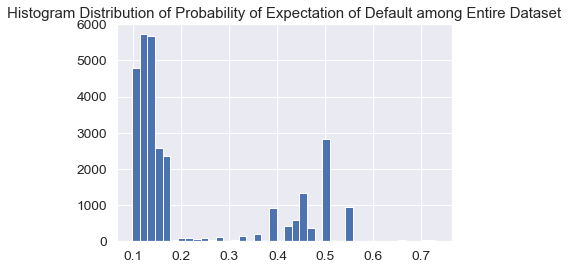

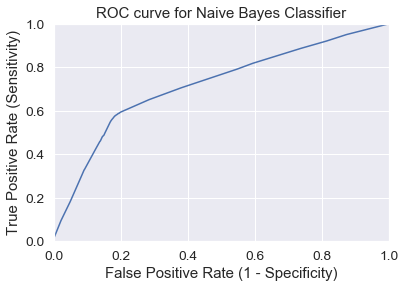

In [164]:
from sklearn import metrics

# Determine probabilities
y_pred_prob = bnb.predict_proba(X1)[:, 1] 
y_pred_prob = y_pred_prob.reshape(-1,1) # gotta reshape for it to work
# This means to predict probabilities of outcome from "class 1" for all rows

#good idea to graph out the probability distribution to get an idea of how to adjust
plt.hist(y_pred_prob, bins=40)
plt.title('Histogram Distribution of Probability of Expectation of Default among Entire Dataset')
plt.ylabel('Count')
plt.xlabel('Percent Probability of Default')
plt.show()

# How to determine this delineating point? How sensitive to make?
# Answer: ROC Curve. 
# ROC Curve tells you what sensitivity/specificity tradeoff you will be able to get

fpr, tpr, thresholds = metrics.roc_curve(Y, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim(0,1) # from 0% to 100%
plt.ylim(0,1)
plt.title('ROC curve for Naive Bayes Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xticks(.1)
plt.yticks(.1)
plt.grid(True)

# also for numerical points along this ROC curve for specific sensitivity, specificity:
def evaluate_threshold(threshold_percent):
    print('Sensitivity:', tpr[thresholds > threshold_percent][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold_percent][-1])

In [266]:
# Let's set sensitivity to 60% (really 58%) in order to lessen false negatives (as seen above)

evaluate_threshold(0.2) # good enough for me (really 1.5)

Sensitivity: 0.5897047691143074
Specificity: 0.8045747086449817


In [267]:
# adjusting y_pred for this new threshold

from sklearn.preprocessing import binarize
y_pred = binarize(y_pred_prob, 0.2)

In [268]:
# evaluating model with new threshold

confusion_matrix(Y, y_pred)

array([[18502,  4494],
       [ 2710,  3895]], dtype=int64)

In [269]:
y_pred = binarize(y_pred_prob, 0.175)
confusion_matrix(Y, y_pred)

array([[18420,  4576],
       [ 2684,  3921]], dtype=int64)

In [207]:
y_pred_reshape = np.reshape(y_pred, 29601) # reshaping to count mislabeled points against Y (see below cell)
y_pred_reshape[:5]

array([0., 1., 0., 0., 0.])

In [222]:
print("Number of MISLABELED points out of a total {} points : {}".format(
    X1.shape[0],
    (Y != y_pred_reshape).sum()
))
accuracyvalue = (100 - (7260/29601*100))
print("Naive Bayes Classifier Accuracy: {}%".format(round(accuracyvalue, 3)))

Number of MISLABELED points out of a total 29601 points : 7260
Naive Bayes Classifier Accuracy: 75.474%


In [223]:
# Now, looking at importance features, using ONLY 'payment timing avg', 'bill amount avg.', 'pay amount avg.'
X2 = X1[['payment timing avg', 'bill amount avg.', 'pay amount avg.']]

In [239]:
# new bernoulli so as not to confuse it with the first one

bnb2 = BernoulliNB()

Y_pred2 = bnb2.fit(X2, Y).predict(X2)

# Display our results.
print("Number of MISLABELED points out of a total {} points : {}".format(
    X2.shape[0],
    (Y != Y_pred2).sum()
))

accuracyvalue = (29601-6511)/29601*100
print('That means a Naive Bayes accuracy of {}%.'.format(round(accuracyvalue, 3)))

# Measure via confusion matrix

confusion_matrix(Y, Y_pred2)

Number of MISLABELED points out of a total 29601 points : 6511
That means a Naive Bayes accuracy of 78.004%.


array([[22959,    37],
       [ 6474,   131]], dtype=int64)

In [240]:
# note slightly better with focus on the three variables, but a much much sensitivity.
v
y_pred_prob2 = y_pred_prob2.reshape(-1,1)
y_pred2 = binarize(y_pred_prob2, 0.175) # changing the range apparently doesn't change the values (at all?!)
confusion_matrix(Y, Y_pred2)

array([[22959,    37],
       [ 6474,   131]], dtype=int64)

In [319]:
y_pred_prob2

array([[0.13063064],
       [0.47067142],
       [0.13063064],
       ...,
       [0.47067142],
       [0.13063064],
       [0.13063064]])

PLACEHOLDER CELL FOR ANALYSIS ON NAIVE BAYES

In [275]:
# maybe a better way to even out the amount of 0's and 1's - 
# a more even amount would generate less biased data when looking at confusion matrices

df0 = df[df['default payment next month'] == 0]

df0 = df0.sample(n=6605, random_state=42)

ID                            6605
LIMIT_BAL                     6605
SEX                           6605
EDUCATION                     6605
MARRIAGE                      6605
AGE                           6605
PAY_0                         6605
PAY_2                         6605
PAY_3                         6605
PAY_4                         6605
PAY_5                         6605
PAY_6                         6605
BILL_AMT1                     6605
BILL_AMT2                     6605
BILL_AMT3                     6605
BILL_AMT4                     6605
BILL_AMT5                     6605
BILL_AMT6                     6605
PAY_AMT1                      6605
PAY_AMT2                      6605
PAY_AMT3                      6605
PAY_AMT4                      6605
PAY_AMT5                      6605
PAY_AMT6                      6605
default payment next month    6605
payment timing sum            6605
payment timing avg            6605
bill amount avg.              6605
pay amount avg.     

In [294]:
df1 = df[df['default payment next month'] == 1]

dfequal = pd.concat([df0, df1]).reset_index()
dfequal.drop(['index'], axis=1, inplace=True)
dfequal.head()


ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0   7198     100000    1          2         0   39      0      0      0   
1  29495     320000    0          0         1   34      0      0      0   
2   5253     420000    1          0         1   29     -2     -2     -2   
3   5728     180000    0          0         0   49      0      0      0   
4  17901      50000    0          1         1   28      1      2      2   

   PAY_4       ...         PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0      0       ...             1663      1471      1360      1212      4472   
1      0       ...            11550     11688     12122     12156      2437   
2     -2       ...             5000      2679      1622      6080      3594   
3      0       ...             4000      5000      3000      5000      5000   
4     -2       ...                0         0         0         0         0   

   default payment next month  payment timing sum  payment timing avg  \
0                           0            0.000000            0.000000   
1                           0            0.000000            0.000000   
2                           0           -2.000000           -2.000000   
3                           0            0.000000            0.000000   
4                           0           -0.166667           -0.166667   

   bill amount avg.  pay amount avg.  
0      41466.166667      1971.166667  
1      99362.833333     11533.166667  
2       3222.333333      3863.333333  
3      69445.000000      4166.666667  
4      17358.833333         0.000000  

[5 rows x 29 columns]

In [295]:
# trying again with new equal dataset to see if that changes anything
Xequal = dfequal[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                  'payment timing avg', 'bill amount avg.', 'pay amount avg.']]

Yequal = dfequal['default payment next month']

In [297]:
# doing another naive bayes bernoulli

bnb = BernoulliNB()

Y_predequal = bnb.fit(Xequal, Yequal).predict(Xequal)

# Display our results.
print("Number of MISLABELED points out of a total {} points : {}".format(
    Xequal.shape[0],
    (Yequal != Y_predequal).sum()
))
print('That means a Naive Bayes accuracy of {}%.'.format((29601-6525)/29601 * 100))
print('That means a Naive Bayes accuracy of {}%.'.format((13210-4027)/13210 * 100))

# Measure via confusion matrix
confusion_matrix(Yequal, Y_predequal)

Number of MISLABELED points out of a total 13210 points : 4027
That means a Naive Bayes accuracy of 77.95682578291274%.
That means a Naive Bayes accuracy of 69.51551854655564%.


array([[5288, 1317],
       [2710, 3895]], dtype=int64)

In [298]:
# switching it up with different threshold value
y_pred_prob_equal = bnb.predict_proba(Xequal)[:, 1] 
y_pred_prob_equal = y_pred_prob_equal.reshape(-1,1)


In [314]:
y_pred_equal = binarize(y_pred_prob_equal, 0.45)
confusion_matrix(Yequal, y_pred_equal)

array([[5256, 1349],
       [2678, 3927]], dtype=int64)

In [315]:
y_pred_equal = binarize(y_pred_prob_equal, 0.4)
confusion_matrix(Yequal, y_pred_equal)

array([[4711, 1894],
       [2302, 4303]], dtype=int64)

In [318]:
y_pred_equal = binarize(y_pred_prob_equal, 0.375)
confusion_matrix(Yequal, y_pred_equal)

array([[4062, 2543],
       [1941, 4664]], dtype=int64)

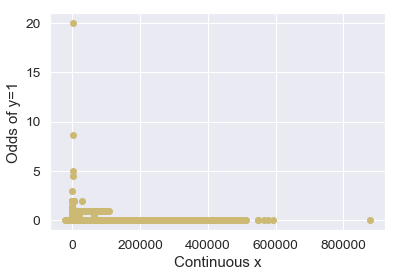

In [245]:
# Model No. 2 - Logistic Regression

# Find the unique values of x
xvals = X2['bill amount avg.'].unique()

# Calculate and store the odds.
yodds = []

for xi in xvals: 
    y1_ct = Y[X2['bill amount avg.'] == xi].sum()  # The number of trials y = 1.
    y0_ct = len(Y[X2['bill amount avg.'] == xi]) - y1_ct  # The number of trials y = 0.
    yodds.append(y1_ct / y0_ct)  # Odds of getting y = 1 for xi.
# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, yodds, 1)

# Work as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display our work.
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('Odds of y=1')
plt.show()

In [ ]:
# using y_predict_prob values as y values
y_pred_prob2 = bnb2.predict_proba(X2)[:, 1] 

ValueError: x and y must be the same size

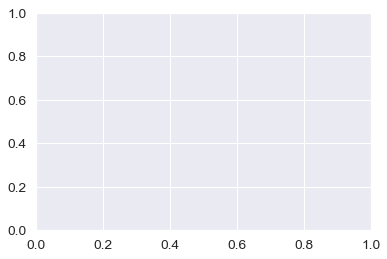

In [320]:
plt.scatter(X2, y_pred_prob2)
plt.show()

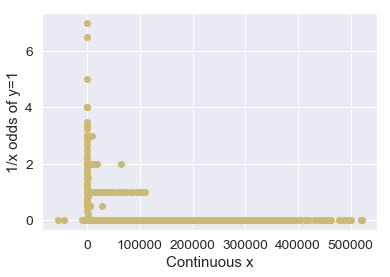

In [247]:
# Doing a 1/x transformation for that data for more linearity
reciprocal_yodds = [1/x for x in yodds]

# Calculate linear regression for x and yodds.
fit = np.polyfit(xvals, reciprocal_yodds, 1)

# Works as a function to return the predicted value of yodds.
fit_fn = np.poly1d(fit)

# Display.
plt.plot(xvals, reciprocal_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('Continuous x')
plt.ylabel('1/x odds of y=1')

plt.show()
